In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import csv

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
def clean_homeaway_row(row):
    row_price_clean = re.sub(r'[\$,]', '', row.price)
    row.price = int(row_price_clean)
    row.rating = np.nan if np.isnan(row.rating) else float(row.rating)
    row.number_reviews = 0 if np.isnan(row.number_reviews) else int(row.number_reviews)
    row.bathrooms = int(row.bathrooms)
    row.bedrooms = 0 if (row.bedrooms == 'Studio') else int(row.bedrooms)
    row.geo_lat = float(row.geo_lat)
    row.geo_long = float(row.geo_long)
    row.title = str.lower(row.title)
    
    # Clean minimum stay string
    if isinstance(row.min_stay, str):
        nights = row.min_stay.replace('nights', '').strip()
        nights = [int(n) for n in nights.split('-')]
        min_stay = np.floor(np.average(nights))
    elif(row.min_stay):
        min_stay = 1
    row.min_stay = min_stay
    return row
    
def clean_homeaway_data(df):
    df = df.drop_duplicates(subset=['url'])
    df = df[df.price.notnull()]
    df = df.apply(clean_homeaway_row, axis=1)
    df = df.drop_duplicates(subset=['title', 'price', 'sleeps'])
    return df
    
# Read amenities data file
data_file_amenities = 'data/homeaway_rentals_nyc_amenities_ALL.txt'
headers_amenities = ['url', 'has_elevator', 'has_concierge', 'has_patio', 'has_pool', 'floor_area']
df_amenities = pd.read_csv(data_file_amenities, sep='\t', header=None, names=headers_amenities)

# Read descriptions data file
data_file_descriptions = 'data/homeaway_rentals_nyc_descriptions.txt'
headers_description = ['url', 'title', 'description']
df_descriptions = pd.read_csv(data_file_descriptions, sep='\t', header=None, names=headers_description)
df_descriptions = df_descriptions.drop_duplicates(subset=['url'])

# Read main rental file
data_file = 'data/homeaway_rentals_nyc_ALL.txt'
headers = ['url', 'price', 'title_partial', 'geo_lat', 'geo_long', 'rating',
           'number_reviews', 'sleeps', 'bedrooms', 'bathrooms',
           'min_stay']

df = pd.read_csv(data_file, sep='\t', header=None, names=headers)

# Merge in amenities and descriptions
df = pd.merge(df, df_amenities, on='url')
df = pd.merge(df, df_descriptions, on='url')

df = clean_homeaway_data(df)
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,floor_area
count,3.999000e+03,3999.000000,3999.000000,1630.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,1779.000000
mean,3.693854e+04,40.739378,-73.972715,4.563742,6.602151,5.078770,1.832708,1.302576,9.169542,990.888702
std,2.313467e+06,0.050603,0.060158,0.611546,16.194880,2.826401,1.154745,0.752499,12.314852,832.756653
min,0.000000e+00,40.461098,-74.357016,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.630000e+02,40.714703,-73.994438,4.400000,0.000000,3.000000,1.000000,1.000000,2.000000,550.000000
50%,2.500000e+02,40.743607,-73.979955,4.800000,0.000000,4.000000,2.000000,1.000000,3.000000,796.000000
75%,4.000000e+02,40.766146,-73.951811,5.000000,4.000000,6.000000,2.000000,1.000000,7.000000,1162.000000
max,1.462985e+08,40.974511,-73.673384,5.000000,175.000000,38.000000,15.000000,23.000000,180.000000,10763.000000


(array([  2.68000000e+02,   1.14900000e+03,   9.66000000e+02,
          5.66000000e+02,   3.62000000e+02,   2.25000000e+02,
          1.14000000e+02,   7.00000000e+01,   6.30000000e+01,
          3.60000000e+01,   3.40000000e+01,   2.90000000e+01,
          1.60000000e+01,   1.60000000e+01,   1.60000000e+01,
          1.00000000e+01,   9.00000000e+00,   7.00000000e+00,
          5.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          5.00000000e+00]),
 array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
         1600.,  1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,
         2400.,  2500.]),
 <a list of 25 Patch objects>)

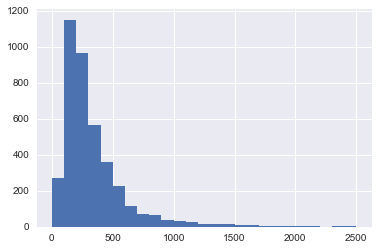

In [3]:
# Histogram of nightly prices
plt.hist(df.price, bins = 25, range=(0,2500))

In [4]:
number_pools = len(df_amenities.loc[df_amenities.has_pool == True])
number_elevators = len(df_amenities.loc[df_amenities.has_elevator == True])
number_concierge = len(df_amenities.loc[df_amenities.has_concierge == True])
number_patio = len(df_amenities.loc[df_amenities.has_patio == True])
number_floor_area = len(df_amenities.loc[df_amenities.floor_area.isnull()])

print('''Pool count: {}
Has elevator count: {}
Has concierge count: {}
Has patio count: {}
Has Floor Area size: {}'''.format(
    number_pools, number_elevators, number_concierge, number_patio, number_floor_area
))

print('-- Nonsensical Data points --')
# Find number of outliers
print('# Rentals with nightly price >= $3000:', (df.loc[df.price >= 3000].shape[0]))
print('# Rentals with minimum # night stay >= 100:', (df.loc[df.min_stay >= 100].shape[0]))
print('# Rentals with # bedrooms >= 10:', (df.loc[df.bedrooms >= 10].shape[0]))
print('# Rentals with # bathrooms >= 10:', (df.loc[df.bathrooms >= 10].shape[0]))
print('# Rentals with # bathrooms = 0:', (df.loc[df.bathrooms == 0].shape[0]))
print('# Rentals with sleeps >= 10:', (df.loc[df.bathrooms >= 10].shape[0]))
print('# Rentals with sleeps = 0:', (df.loc[df.sleeps == 0].shape[0]))
print('# Rentals with price <= $10:', (df.loc[df.price <= 10].shape[0]))

Pool count: 293
Has elevator count: 1316
Has concierge count: 589
Has patio count: 656
Has Floor Area size: 2585
Nonsensical Data points:
# Rentals with nightly price >= $3000: 13
# Rentals with minimum # night stay >= 100: 2
# Rentals with # bedrooms >= 10: 2
# Rentals with # bathrooms >= 10: 1
# Rentals with # bathrooms = 0: 66
# Rentals with sleeps >= 10: 1
# Rentals with sleeps = 0: 2
# Rentals with price <= $10: 7


In [5]:
# Remove these non-sensical outliers
df = df[df.price < 3000]
df = df[df.bedrooms < 10]
df = df[df.min_stay < 100]
df = df[df.bathrooms < 10]
df = df[df.bathrooms > 0]
df = df[df.sleeps < 10]
df = df[df.sleeps > 0]
df = df[df.price > 10]

In [6]:
# Merge Homeaway rental data with location data collected from Google Places API 
data_file_TS_distances = 'data/homeaway_urls_times_square.csv'
data_file_subway_counts = 'data/homeaway_urls_subway.csv'

def url_to_TS_distance():
    url_to_distance = {}
    with open(data_file_TS_distances, 'r') as f:
        for TS_line in csv.reader(f, delimiter='\t'):
            url_to_distance[TS_line[1]] = TS_line[4]
    return url_to_distance

def url_to_subway_count():
    url_to_count = {}
    with open(data_file_subway_counts, 'r') as f:
        for subway_count in csv.reader(f, delimiter='\t'):
            url_to_count[subway_count[1]] = subway_count[4]
    return url_to_count

def add_geo_data(row, url_to_distance, url_to_subway):
    url = row.url
    distance_meters = int(url_to_distance[url])
    distance_miles = distance_meters * 0.000621371
    row.distance_to_TS = distance_miles
    row.distance_to_TS_meter = distance_meters
    # subway_count = url_to_subway[url]
    # row.subway_count = int(subway_count)
    return row


def merge_data(df):
    # df['subway_count'] = None
    df['distance_to_TS_meter'] = None
    df['distance_to_TS'] = None
    df = df.apply(lambda row: add_geo_data(row, url_to_TS_distance(), url_to_subway_count()), axis=1)
    return df
    
# df.loc[df.url == 'https://www.homeaway.com/vacation-rental/p1120220vb'] # missing subway?
df = merge_data(df)
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,floor_area,distance_to_TS_meter,distance_to_TS
count,3644.000000,3644.000000,3644.000000,1450.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,1575.000000,3644.000000,3644.000000
mean,318.572722,40.739994,-73.972336,4.568345,6.504116,4.541712,1.670966,1.246432,9.519210,862.606349,8802.189901,5.469426
std,269.975711,0.049526,0.057909,0.613814,16.227714,1.825390,0.937007,0.527244,12.125133,518.740721,8191.737378,5.090108
min,19.000000,40.551015,-74.349691,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,51.000000,0.031690
25%,158.000000,40.715898,-73.993907,4.400000,0.000000,3.000000,1.000000,1.000000,2.000000,500.000000,2845.000000,1.767800
50%,245.000000,40.743813,-73.979950,4.800000,0.000000,4.000000,2.000000,1.000000,3.000000,750.000000,5918.500000,3.677584
75%,385.250000,40.766506,-73.952319,5.000000,4.000000,6.000000,2.000000,1.000000,10.000000,1000.000000,12707.250000,7.895917
max,2688.000000,40.974511,-73.679948,5.000000,175.000000,9.000000,6.000000,6.000000,90.000000,5000.000000,47405.000000,29.456092


In [7]:
# Remove more outliers
df = df[df.distance_to_TS < 20]

In [8]:
floor_size_medians = [df.floor_area[df.bedrooms == bedroom_size].median() for bedroom_size in range(0, 7)]
rating_median = df.rating.median()

print('Floor Sq Ft median: ', floor_size_medians)
print('Rating median:', rating_median)

def add_missing_data(row):
    number_bedrooms = row.bedrooms
    # impute #bedrooms
    if np.isnan(row.floor_area):  
        # https://www.rentcafe.com/blog/rental-market/us-average-apartment-size-trends-downward/
        if number_bedrooms == 6:     # no examples exist
            row.floor_area = 5000 
        else:
            row.floor_area = floor_size_medians[number_bedrooms]
    # impute rating
    if np.isnan(row.rating):
        row.rating = rating_median
    return row

df = df.apply(add_missing_data, axis=1)

Floor Sq Ft median:  [450.0, 650.0, 900.0, 1200.0, 2000.0, 4200.0, nan]
Rating median: 4.8


In [9]:
df.describe()

,price,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,floor_area,distance_to_TS_meter,distance_to_TS
count,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000,3545.000000
mean,319.008181,40.742916,-73.973800,4.709929,6.543583,4.522708,1.654161,1.240621,9.606488,864.404231,7985.072779,4.961693
std,267.393718,0.045451,0.047617,0.402262,16.342531,1.816996,0.925254,0.520936,12.121074,455.860532,6628.695069,4.118879
min,19.000000,40.571015,-74.257572,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,51.000000,0.031690
25%,160.000000,40.718100,-73.993685,4.800000,0.000000,3.000000,1.000000,1.000000,2.000000,650.000000,2827.000000,1.756616
50%,247.000000,40.745020,-73.980246,4.800000,0.000000,4.000000,2.000000,1.000000,3.000000,750.000000,5644.000000,3.507018
75%,386.000000,40.767085,-73.952842,4.800000,4.000000,6.000000,2.000000,1.000000,11.000000,900.000000,11440.000000,7.108484
max,2688.000000,40.974511,-73.712820,5.000000,175.000000,9.000000,6.000000,6.000000,90.000000,5000.000000,32177.000000,19.993855


In [10]:
# Write to file to be used for modeling
filename = 'data/homeaway_rentals_nyc_PARSED.csv' 
#print('Writing to ', filename)
#df.to_csv(filename, sep='\t')

Writing to  data/homeaway_rentals_nyc_PARSED.csv


In [17]:
#df.loc[(df.has_pool) & (df.price < 100)]
#df.loc[(df.price > 250)][['title', 'price']]
pd.set_option('display.max_colwidth', -1)
df[df['title'].str.contains("\broom\b|shared")]


,url,price,title,geo_lat,geo_long,rating,number_reviews,sleeps,bedrooms,bathrooms,min_stay,has_elevator,has_concierge,has_patio,has_pool,floor_area,distance_to_TS_meter,distance_to_TS
769,https://www.homeaway.com/vacation-rental/p1056148vb,227,top floor townhouse apt with shared roof... - homeaway midtown east,40.743676,-73.977805,4.7,3,3,1,1,2.0,False,False,True,False,650.0,2998,1.862870
808,https://www.homeaway.com/vacation-rental/p1056387vb,224,large townhouse apt with shared roof... - homeaway midtown east,40.743676,-73.977784,4.8,0,3,1,1,2.0,False,False,True,False,650.0,2997,1.862249
845,https://www.homeaway.com/vacation-rental/p4325766,80,dorm style studio with shared bathroom... - homeaway harlem,40.799868,-73.946766,4.5,4,5,1,1,1.0,False,False,False,False,650.0,6170,3.833859
860,https://www.homeaway.com/vacation-rental/p1029133vb,55,cozy private room!!!in a shared house... - homeaway bath beach,40.610738,-74.011765,4.3,6,2,1,1,2.0,False,False,True,False,1000.0,23670,14.707852
1310,https://www.homeaway.com/vacation-rental/p1097478vb,121,brand new two bedrooms shared two full... - homeaway east flushing,40.756655,-73.813003,4.8,0,6,2,2,1.0,False,False,False,False,1900.0,19465,12.094987
4228,https://www.homeaway.com/vacation-rental/p6883681,56,exquisite single bedroom in shared apartment... - homeaway upper east side,40.763628,-73.958969,4.8,0,1,1,1,28.0,True,True,False,False,650.0,3280,2.038097
5144,https://www.homeaway.com/vacation-rental/p1055877vb,75,room in shared apartment steps from central... - homeaway harlem,40.796931,-73.946724,4.8,0,2,1,1,7.0,False,False,False,False,650.0,9431,5.860150
5286,https://www.homeaway.com/vacation-rental/p4628210,43,shared living in charming crown heights... - homeaway crown heights,40.674616,-73.951112,4.8,0,1,3,1,30.0,False,False,False,False,1200.0,16060,9.979218
5293,https://www.homeaway.com/vacation-rental/p4628207,40,shared living in charming crown heights... - homeaway crown heights,40.675985,-73.950625,4.8,0,1,3,1,30.0,False,False,False,False,1200.0,15890,9.873585
